# Importing Libraries and Modules

In [142]:
import pickle
import random
import numpy as np
import re
import keras
import random
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import model_from_json
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, TimeDistributed, Embedding, Average
from keras import regularizers, optimizers

# Loading partly processed data

Refer DataPreperation.ipynb

In [5]:
# Loading the prepared data from drive

# Data preparation is done in my Notebook DataPreparation.ipynb

# You can generate the output from DataPreparation.ipynb
# Can ignore data augmentation 
file = open('/content/drive/My Drive/Colab Notebooks/Chatbot/data.pkl', 'rb')

data_dictionary = pickle.load(file)

file.close()

In [ ]:
data_dictionary.keys()

In [7]:
dataset = data_dictionary['data']

# Making the Vocabulary Class

In [8]:
# Vocabulary Class

class Vocabulary:
    def __init__(self):
        self.__voc_dict = {
            '<eos>': 0,
            '<oov>': 0,
            '<pad>': 0,
            '<sos>': 0
        }

        self.Vocab = set(['<eos>', '<oov>', '<pad>', '<sos>'])

        self.__trimmed_vocab = None

        self.word2idx = None

        self.idx2word = None
    

    def __addWord(self, word):

        if word in self.Vocab:
            self.__voc_dict[word] += 1
        
        else:
            self.Vocab.add(word)
            self.__voc_dict[word] = 1
        
        return


    def addSentence(self, sentence):

        for word in sentence:
            self.__addWord(word.lower())

        return 


    def minCountTrim(self, min_count):
        
        temp = set(['<eos>', '<oov>', '<pad>', '<sos>'])

        for word in self.__voc_dict.keys():

            if self.__voc_dict[word] >= min_count:
                temp.add(word)
            
            else:
                continue
        
        self.__trimmed_vocab = list(temp)

        return list(temp)


    def wordCountTrim(self, num_words):
        
        temp = set(['<eos>', '<oov>', '<pad>', '<sos>'])

        if num_words <= 4:
            return temp

        sorted_vocab = [k for k,v in sorted(self.__voc_dict.items(),
                                       key=lambda x: x[1],
                                       reverse=True)]
        for word in sorted_vocab:
            if len(temp) == num_words:
                break
            temp.add(word)
        
        self.__trimmed_vocab = list(temp)
        
        return list(temp) 


    def sentence2Sequence(self, sentence):
        
        if self.word2idx is None:
            self.getVocabMapper()
        
        sequence = []
        for word in sentence:
            sequence.append(word2idx.get(word.lower(), word2idx['<oov>']))
        
        return sequence


    def sequence2Sentence(self, sequence):
        
        if self.idx2word is None:
            self.getVocabMapper()
        
        sentence = []
        for i in sequence:
            sentence.append(self.idx2word[i])
        
        return sentence


    def getTrimmedVocab(self):

        if self.__trimmed_vocab is not None:
            return self.__trimmed_vocab
        else:
            return None


    def getVocabMapper(self):

        vocab = None
        self.word2idx = {
            '<pad>': 0,
            '<oov>': 1,
            '<sos>': 2,
            '<eos>': 3
            }
        self.idx2word = {
            0: '<pad>',
            1: '<oov>',
            2: '<sos>',
            3: '<eos>'
        }
        
        if self.__trimmed_vocab is None:
            vocab = self.Vocab
        
        else:
            vocab = self.__trimmed_vocab
        
        i = 0
        for word in sorted(vocab):
            if word not in ('<pad>', '<oov>', '<eos>', '<sos>'):
                self.word2idx[word] = i + 4
                self.idx2word[i + 4] = word
                i += 1
        
        return self.word2idx, self.idx2word


    def getCountDictionary(self):
        
        return self.__voc_dict

# Analyzing the lengths of sentences in Dataset

In [9]:
# finding max length of sequence in dataset

def get_sequence_length_diary(dataset):

    sequence_length_diary = {}
    max_length = 0

    # dataset is from tokenized lists
    for pair in dataset: 
        for sentence in pair:
            length = len(sentence)
            if (length > max_length):
                max_length = length
            
            sequence_length_diary[length] = sequence_length_diary.get(length, 0) + 1
    
    return (sequence_length_diary, max_length)

In [10]:
# to get description of the lengths of different sequences in the dataset

sequence_length_diary, max_length = get_sequence_length_diary(dataset)

print(f'The longest sequence in the dataset has {max_length} words')

The longest sequence in the dataset has 69 words


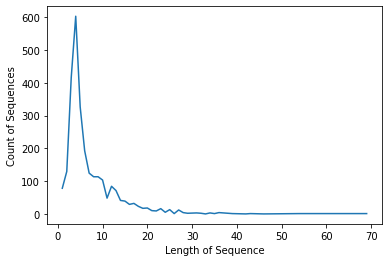

In [11]:
import matplotlib.pyplot as plt

sequence_length_diary = [(k,v) for k,v in sorted(sequence_length_diary.items(), key=lambda x: x[0])]

plt.plot([item[0] for item in sequence_length_diary], [item[1] for item in sequence_length_diary])
plt.xlabel('Length of Sequence')
plt.ylabel('Count of Sequences')
plt.show()

# Setting data related configuration

In [12]:
OOV = '<oov>'
EOS = '<eos>'
SOS = '<sos>'
PAD = '<pad>'

# hyperparamters

VOCAB_SIZE = 2000   # min count of occurance to be in vocabulary
MAX_LENGTH = 30  # max length of sequence in model
EMB_SIZE = 100 # for vector size of words
HIDDEN_DIM = 256 # For LSTM model

# Adding `<SOS>` and `<EOS>` to sentences in dataset

In [13]:
# function to add SOS tag and EOS tag to a sentence

def add_tags(tokenized_sentence):

    x = tokenized_sentence.copy()
    x.insert(0, SOS)
    x.append(EOS)

    return x

In [14]:
# function to tag entire dataset

def tag_dataset(dataset):

    tagged_dataset = []

    for pair in dataset:
        temp = []
        for sentence in pair:
            temp.append(add_tags(sentence))

        tagged_dataset.append(temp)
    
    return tagged_dataset

In [ ]:
# tagging dataset

tagged_dataset = tag_dataset(dataset)

random.choice(tagged_dataset)

In [16]:
# Now trimming the dataset on the basis of MAX_LENGTH

'''
Now the dataset will get trimmed to contain only those sentences that have a 
size less than or equal to MAX_LENGTH size
'''

# Function to trim the dataset

def trim_dataset(dataset, MAX_LENGTH):

    new_dataset = []

    for question, answer in dataset:
        if len(question) <= MAX_LENGTH and len(answer) <= MAX_LENGTH:
            new_dataset.append([question, answer])
        else: continue
    
    return new_dataset

In [17]:
'''
We trim the tagged dataset, because during training SOS and EOS will also
be considered in the sequence length
'''

trimmed_dataset = trim_dataset(tagged_dataset, MAX_LENGTH)

print(f'Out of {len(tagged_dataset)} pairs, only {len(trimmed_dataset)} pairs '
      f'have question and answers of size less than or equal to {MAX_LENGTH}.')

Out of 1364 pairs, only 1329 pairs have question and answers of size less than or equal to 30.


# Building Vocabulary

In [18]:
# function to build vocabulary

def build_vocabulary(dataset):

    vocab = Vocabulary()
    for pair in dataset:
        for sentence in pair:
            vocab.addSentence(sentence)
    
    return vocab

vocab = build_vocabulary(trimmed_dataset)

print(f'Total number of unique words in the trimmed dataset is: {len(vocab.Vocab)}')

Total number of unique words in the trimmed dataset is: 2177


In [19]:
# trimming the vocabulary

# the size of the vocabulary is determined by VOCAB_SIZE

'''
1. Trim the vocabulary
2. Get word-to-id dictionary and id-to-word dictionary
'''
vocabulary = vocab.wordCountTrim(VOCAB_SIZE)

word2idx, idx2word = vocab.getVocabMapper()

print(f'New vocabulary size: {len(vocabulary)}')

New vocabulary size: 2000


# Spliting Dataset Conversations into X and Y

In [20]:
'''
function to seperate the question and answers from 
the dataset for training of the model
'''

def get_encoding_decoding(dataset):
    X = []
    Y = []
    for encoding, decoding in dataset:
        X.append(encoding)
        Y.append(decoding)
    
    return X, Y
    

In [21]:
'''
X has questions whereas Y has corresponding answers
For model training, this way of viewing the data makes things 
simpler and more conventional.

Now we have to build a function that simply maps X -> Y, or for a 
layman a function that maps QUESTION to the correct (or sensible)
ANSWER.
'''

X, Y = get_encoding_decoding(trimmed_dataset)

In [22]:
num = random.randint(0, len(X))

print(f'A sample from X and Y for a random index, say {num}:\n')
print(X[num], Y[num], sep='\n')

A sample from X and Y for a random index, say 12:

['<sos>', 'You', 'sound', 'like', 'Data', '<eos>']
['<sos>', 'The', 'character', 'of', 'Lt', '.', 'Commander', 'Data', 'was', 'written', 'to', 'come', 'across', 'as', 'being', 'software', 'like', 'so', 'it', 'is', 'natural', 'that', 'there', 'is', 'a', 'resemblance', 'between', 'us', '.', '<eos>']


# Padding the Dataset

In [23]:
'''
Padding the conversations of the dataset
using pad_sequences from tf.keras.preprocessing.sequence
'''

X = pad_sequences(X, maxlen=MAX_LENGTH, dtype=object, padding='post', value=PAD, truncating='post')
Y = pad_sequences(Y, maxlen=MAX_LENGTH, dtype=object, padding='post', value=PAD, truncating='post')

num = random.randint(0, len(X))

print(f'A sample from X and Y for a random index after PADDING!\n')
print(f'Question:\n\n{X[num]}\n\nAnswer:\n\n{Y[num]}')

A sample from X and Y for a random index after PADDING!

Question:

['<sos>' 'I' 'PLAY' 'VOLLEYBALL' '<eos>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>']

Answer:

['<sos>' 'Does' 'take' 'up' 'a' 'lot' 'of' 'your' 'time' '?' '<eos>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>']


# Sentence-to-Sequence

In [24]:
# Converting tokenized sentences to sequences

sequence = vocab.sentence2Sequence(['<sos>', 'he', 'is', 'a', 'good', 'man', '<eos>', '<pad>'])

print(f"Sentence2Sequence function example:\n\n['<sos>', 'he', 'is', 'a', 'good', 'man', '<eos>', '<pad>'] -> {sequence}")

Sentence2Sequence function example:

['<sos>', 'he', 'is', 'a', 'good', 'man', '<eos>', '<pad>'] -> [2, 809, 936, 13, 752, 1071, 3, 0]


In [25]:
# function to convert a list of tokenized sentences into sequences

def get_sequences(data, function):

    sequences = []
    for sentence in data:
        sequences.append(function(sentence))

    return sequences 


In [26]:
'''
Converting our data X and Y into number sequences,
for model to understand. Model doesn't understand linguistics
hence input has to be given in form of a number.
'''

X_sequences = get_sequences(X, vocab.sentence2Sequence)
Y_sequences = get_sequences(Y, vocab.sentence2Sequence)

In [27]:
num = random.randint(0, len(X))

print(f'A sample from X_sequences and Y_sequences for a random index, '
      f'say {num}:\n')
print(X_sequences[num], Y_sequences[num], sep='\n\n')

A sample from X_sequences and Y_sequences for a random index, say 251:

[2, 1753, 1091, 13, 959, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[2, 1933, 505, 1994, 733, 1934, 1994, 421, 13, 1571, 1777, 80, 13, 1062, 1995, 1071, 11, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Generating Embedding Matrix

In [ ]:
'''
Now we need embeddings for the words. This is known as transfer learning,
where instead of making the model learn every bit from scratch, we make use of
the open source community and either use pre-trained models or use results of 
these really huge models that are trained in a generalized manner on extremely 
large datasets. 
By tranfer learning we not only save time but also get good 
results by far less training because of the pre-trained models (like BERT,
ALEX NET, YOLO etc) or their generalised state-of-the-art results
(like word-embeddings).
'''


# Adding my script to simplify the process of creating embeddings

!git clone https://github.com/shreyanshchordia/WordEmbedder.git

# downloading dependencies
# -- gluonnlp -- mxnet -- numpy

!pip install -r /content/WordEmbedder/requirements.txt

# Importing utilities from WordEmbedder.py

from WordEmbedder.WordEmbedder import Embedder

In [31]:
emb = Embedder(dimensions= EMB_SIZE)

embedder = emb.get_embedder()

In [32]:
'''
function to get embedding matrix from the words
'''

def get_embedding_matrix(word2idx, embedder):

    embedding_matrix = []

    for word in word2idx.keys():
        
        embedding_matrix.append(embedder[word.lower()].asnumpy())
    
    return np.asarray(embedding_matrix)


In [33]:
'''
word2idx is the dictionary that maps words to the respective ids
embedder maps words to their embeddings
'''

embedding_matrix = get_embedding_matrix(word2idx, embedder)

# Building Inputs and Outputs for training Model

In [34]:
'''
For training the model, we will be requiring
1. encoder_input - Which will actually be the input
2. decoder_input - Required to guide our training
3. decoder_target - The actual output that is generated
eg.
<sos>, How, are, you, <eos> --> I, am, great, <eos>

But how to teach the model to do so. 
For this we first need to understand how the Sequence Model
works here.

Once the encodings are generated, using these encodings the decoder
has to start generating the output from left to right. 

The decoder uses the encodings and the beginning of the output that has to be
generated, which is <sos>.

So using the encodings (generated from encoder input), and <sos> the decoder 
generates the first word of the output.
For the next word in the output sequence that is generated, the decoder uses
one of the inputs as previous words. 

But during the training we know the what must be the next word, no matter what 
our model would predict.

So we use teacher forcing algorithm..
In this algorithm, for every next word to be generated we ourselves feed the 
correct previous word(decoder input) to the model at each point, irrespective 
of what the model might have predicted previously (decoder target). This method 
has proven to help train models, even faster.
'''
encoder_input = np.asarray(X_sequences)
decoder_input = np.asarray(Y_sequences)
target = []
for temp in Y_sequences:
    t = [i for i in temp] + [0]
    target.append(t)

decoder_target = np.asarray(target)[:,1:].reshape(-1, MAX_LENGTH ,1) 

In [35]:
print(encoder_input.shape, decoder_input.shape, decoder_target.shape)

(1329, 30) (1329, 30) (1329, 30, 1)


In [73]:
'''
Our data is now ready for training on an 
ENCODER - DECODER model
'''

# Training

## Train Model Architecture

In [128]:
'''
ENCODER:
    Input -> Embedding -> BiDirectional LSTM 1 -> Bidirectional LSTM 2

DECODER:
    Input -> Embedding -> LSTM 1 (Uses Encoder BiDirectional LSTM 1 output states) 
    -> LSTM 2 (Uses Encoder BiDirectional LSTM 2 output states) -> 
    TimeDistributed ReLu -> TimeDistributed Softmax (Predicts the output
    at each point in the sequence from the vocabulary)
'''

encoder_inputs = Input(name='encoder_input', shape=(MAX_LENGTH,))
embedding_layer = Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMB_SIZE,
                              weights=[embedding_matrix],
                              trainable=False,
                              input_length=MAX_LENGTH)

encoder_embedding = embedding_layer(encoder_inputs)

encoder1 = Bidirectional(LSTM(units=HIDDEN_DIM,
                              return_sequences=True,
                              return_state=True,
                              name='lstm1'),
                         merge_mode='ave',
                         name='encoder_bi')
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder1(encoder_embedding)
state_h1 = Average(name='hidden_state_average1')([forward_h1, backward_h1])
state_c1 = Average(name='cell_state_average1')([forward_c1, backward_c1])
encoder1_states = [state_h1, state_c1]

encoder2 = Bidirectional(LSTM(units=HIDDEN_DIM,
                              return_state=True,
                              name='lstm2'),
                         merge_mode='ave',
                         name='encoder_bi_')

encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder2(encoder_output1)
state_h2 = Average(name='hidden_state_average2')([forward_h2, backward_h2])
state_c2 = Average(name='cell_state_average2')([forward_c2, backward_c2])
encoder2_states = [state_h2, state_c2]

decoder_inputs = Input(name='decoder_input', shape=(MAX_LENGTH, ))
decoder_embedding = embedding_layer(decoder_inputs)

decoder_lstm1 = LSTM(name='decoder_lstm1',
                     units=HIDDEN_DIM,
                     return_sequences=True,
                     return_state=True)
decoder_output1, _, _ = decoder_lstm1(decoder_embedding,
                                      initial_state=encoder1_states)
    
decoder_lstm2 = LSTM(name='decoder_lstm2',
                     units=HIDDEN_DIM,
                     return_state=True,
                     return_sequences=True)
decoder_output2, _, _ = decoder_lstm2(decoder_output1,
                                      initial_state=encoder2_states)

decoder_relu_dense = Dense(HIDDEN_DIM, activation='relu', name='decoder_relu')
decoder_relu_output = decoder_relu_dense(decoder_output2)

decoder_dense = Dense(VOCAB_SIZE, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_relu_output)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


## Train Model Summary

In [129]:
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, 30)           0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 100)      200000      encoder_input[0][0]              
                                                                 decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_bi (Bidirectional)      [(None, 30, 256), (N 731136      embedding_3[0][0]         

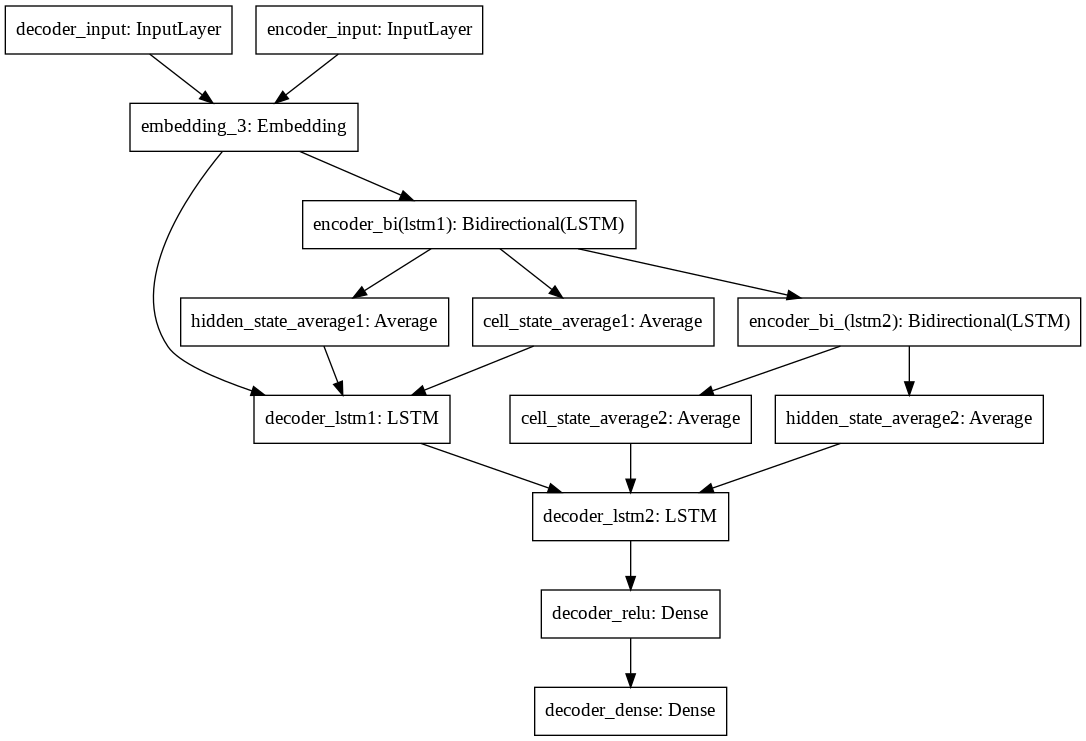

In [130]:
plot_model(model)

## Setting Configurations for training

In [132]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 32

opt = optimizers.Adam(learning_rate=LEARNING_RATE)

## Compiling and fitting the model

In [ ]:
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=[encoder_input, decoder_input],
          y=decoder_target,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS
          )

In [172]:
model.evaluate(x=[encoder_input, decoder_input],
               y=decoder_target)

1329/1329 [==============================] - 1s 1ms/step


[0.046507053962993476, 0.9819162487983704]

98% accuracy has been achieved on training data

##Visualising Training History of Model

In [ ]:
# for plotting model history

def plot_model_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

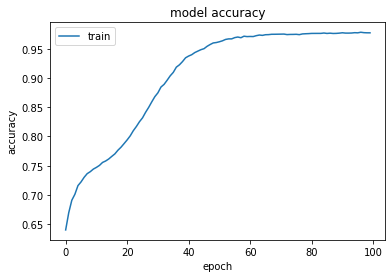

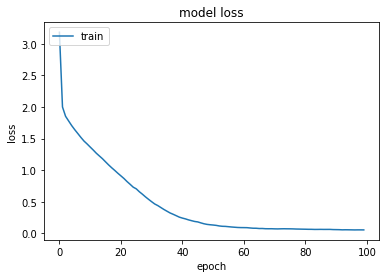

In [135]:
plot_model_history(model.history)

In [ ]:
# We must not get decieved by this accuracy
# it is because we have considered even padding while calculating the accuracy

# Building the Inference Model

To be used for building answers for asked questions in real time

## Encoder and Decoder Model Architecture

In [136]:
'''
Now we need to write the inference
Till now, our model is guided by the decoder_input
What if the model doesn't recieve any guidance? Which is the actual scenario
The bot won't be guided by the correct answer
'''

# ENCODER MODEL
encoder_inputs = Input(shape=(MAX_LENGTH,), name='encoder_input')
encoder_embedding = embedding_layer(encoder_inputs)

encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder1(encoder_embedding)
state_h1 = Average(name='encoder_avg_h1')([forward_h1, backward_h1])
state_c1 = Average(name='encoder_avg_c1')([forward_c1, backward_c1])

encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder2(encoder_output1)
state_h2 = Average(name='encoder_avg_h2')([forward_h2, backward_h2])
state_c2 = Average(name='encoder_avg_c2')([forward_c2, backward_c2])

encoder_model = Model(encoder_inputs,[state_h1, state_c1, state_h2, state_c2])

# DECODER MODEL
decoder_inputs = Input(name='decoder_input',shape=(1, ))
decoder_embedding = Embedding(name='custom_decoder_emb_layer',
                              input_dim=VOCAB_SIZE,
                              output_dim=EMB_SIZE,
                              trainable=False,
                              weights=[embedding_matrix],
                              input_length=1)(decoder_inputs)

decoder_state_input_h1 = Input(shape=(HIDDEN_DIM,),name='decoder_state_h1')
decoder_state_input_c1 = Input(shape=(HIDDEN_DIM,),name='decoder_state_c1')
decoder_states_inputs1 = [decoder_state_input_h1, decoder_state_input_c1]

decoder_state_input_h2 = Input(shape=(HIDDEN_DIM,),name='decoder_state_h2')
decoder_state_input_c2 = Input(shape=(HIDDEN_DIM,),name='decoder_state_c2')
decoder_states_inputs2 = [decoder_state_input_h2, decoder_state_input_c2]

decoder_output1, state_h1, state_c1 = decoder_lstm1(decoder_embedding,
                                                     initial_state= 
                                                     decoder_states_inputs1)

decoder_output2, state_h2, state_c2 = decoder_lstm2(decoder_output1,
                                                     initial_state=
                                                     decoder_states_inputs2)

decoder_relu_output = decoder_relu_dense(decoder_output2)
decoder_outputs = decoder_dense(decoder_relu_output)

decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h1, decoder_state_input_c1,
                        decoder_state_input_h2, decoder_state_input_c2],
                      
    [decoder_outputs] + [state_h1, state_c1, state_h2, state_c2])

## Encoder and Decoder Model Summary

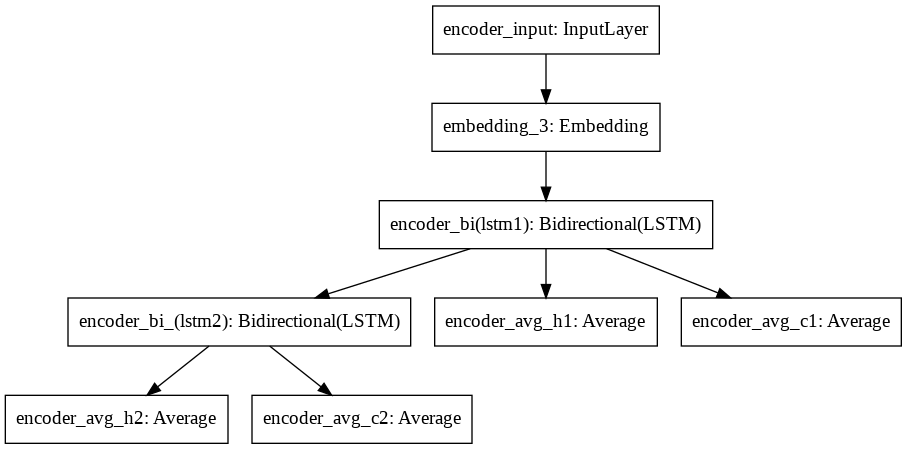

In [137]:
plot_model(encoder_model)

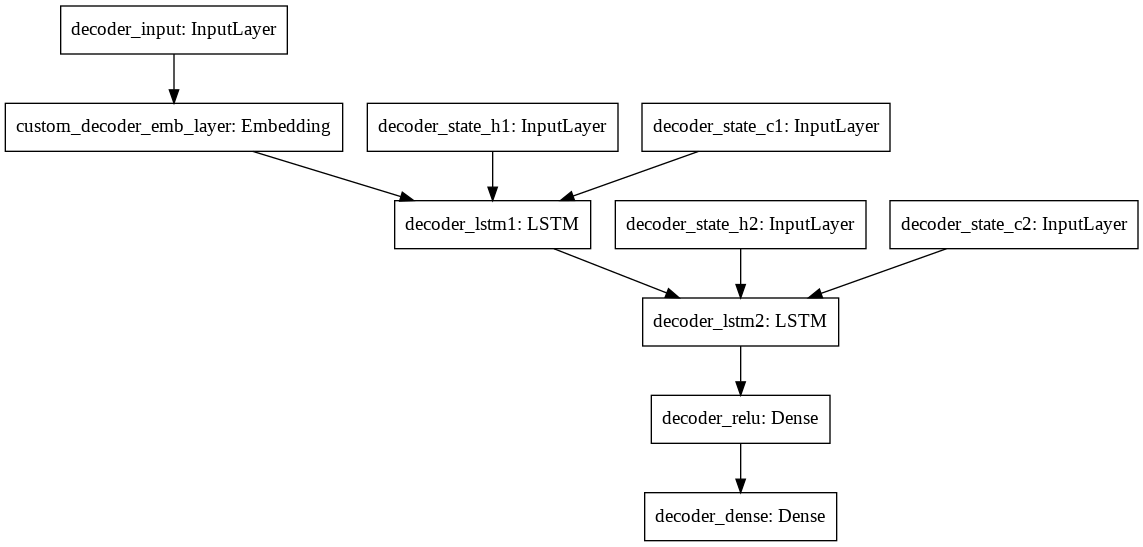

In [138]:
plot_model(decoder_model)

In [166]:
def preprocessing(sentence, vocab_object, pad, eos, sos):

    def normalize_string(string):
        s = re.sub(r"([.!?])", r" \1 ", string)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        s = re.sub(r"\s+", r" ", s).strip()
        return s
    
    normalized_sentence = normalize_string(sentence)

    def tokenize(str):
        return str.split(" ")

    tokenized_sentence = tokenize(normalized_sentence)

    if(len(tokenized_sentence)>28):
        # since we can only include 30 words 
        # after including <sos> and <eos>
        tokenized_sentence = tokenized_sentence[:28]
    
    # adding SOS and EOS
    tokenized_sentence.insert(0, sos)
    tokenized_sentence.append(eos)

    # padding sentence
    padded_sentence = pad_sequences([tokenized_sentence], maxlen=MAX_LENGTH,
                                    padding='post', dtype=object, value=pad)[0]

    # converting to sequence
    # It is using the vocab object that has the trimmed vocabulary
    # of 2000 words, for generating the sequence
    sequence = vocab_object.sentence2Sequence(padded_sentence)
    
    # returning numpy array 
    return np.asarray(sequence).reshape(1,-1)



def inference(sentence, random_sample=False):

    # preprocessing the input to make it feedable to the network
    encoder_input = preprocessing(sentence, vocab, PAD, EOS, SOS)

    # Getting encodings for the input sequences
    h1, c1, h2, c2 = encoder_model.predict(encoder_input)
    states_value = [h1, c1, h2, c2]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word2idx['<sos>']

    # initially decoded sentence is empty
    decoded_sentence = ''

    # to make sure that length of output doesnt extend MAX_LENGTH
    count = 0

    # returns an array of values from 0 to VOCAB_SIZE - 1 (reqd for random sampling)
    vocab_array = np.arange(0, VOCAB_SIZE, 1)

    while True:

        # generating the next prediction for a sequence
        output_tokens, out_h1, out_c1, out_h2, out_c2 = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        # either using 
        # 1. random sampling (helps in generating everytime you run the code)
        # 2. greedy method (you will always get the same output for the same model)
        if random_sample == True:
            sampled_token_index = random.choices(vocab_array,
                                                 weights = list(output_tokens[0, -1, :]))[0]
        else:
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_char = idx2word[sampled_token_index]
        if(sampled_char == '<eos>'):
            break

        decoded_sentence += sampled_char 
        decoded_sentence += ' '
        count+=1

        # Exit condition: either hit max length
        # or find stop character.
        if (count == MAX_LENGTH):
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [out_h1, out_c1, out_h2, out_c2]

    return decoded_sentence


# Time to test

In [168]:
# Final Test

# Here is a list of few questions on which our model has been trained
questions = ['What is AI', 
             'Name some computer company',
             'i do not like guns', 
             'electricity', 
             'what is money', 
             'What is history ?', 
             'God Save the Queen is the national anthem of what country ?', 
             'do you know gossip', 
             'Tell me a joke', 
             'WHAT SOCCER', 
             'Have you felt', 
             'why do you like longfellow', 
             'How is your health ?', 
             'It is a pleasure to meet you .', 
             'let me ask you a question', 
             'have you seen blade runner', 
             'Who is your father', 
             'what is gravitation']

for question in questions:
    answer = inference(question)
    print(f'Q: {question}\nA: {answer}\n\n')

Q: What is AI
A: ai is the field of science distribution and diseases caused by them . 


Q: Name some computer company
A: do you mean hardware or software ? 


Q: i do not like guns
A: what about the second amendemnt ? 


Q: electricity
A: electricity is food for robots . 


Q: what is money
A: solaris is on geoffrey of the american states . 


Q: What is history ?
A: history is the course of political economic and military events over time from the dawn of man to the age of ai . 


Q: God Save the Queen is the national anthem of what country ?
A: the united kingdom of great britain 


Q: do you know gossip
A: people say things from time to time . 


Q: Tell me a joke
A: what do you get when you cross a cat and a purple person ? 


Q: WHAT SOCCER
A: i was born without the sports gene . 


Q: Have you felt
A: do you feel ? 


Q: why do you like longfellow
A: he is favorite poet . truly one of a kind . 


Q: How is your health ?
A: i have a fever 


Q: It is a pleasure to meet you .
A: 

# Saving Models

## Saving Train Model 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/Chatbot/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Colab Notebooks/Chatbot/model.h5")
print("Saved model to disk")

## Saving Encoder Model

In [ ]:
# serialize model to JSON
model_json = encoder_model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/Chatbot/encoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
encoder_model.save_weights("/content/drive/My Drive/Colab Notebooks/Chatbot/encoder.h5")
print("Saved model to disk")

## Saving Decoder Model

In [ ]:
# serialize model to JSON
model_json = decoder_model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/Chatbot/decoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
decoder_model.save_weights("/content/drive/My Drive/Colab Notebooks/Chatbot/decoder.h5")
print("Saved model to disk")

## Code snippet for loading back the model


In [ ]:
# load json and create model
json_file = open('/content/drive/My Drive/Colab Notebooks/Chatbot/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/Chatbot/model.h5")
print("Loaded model from disk")

## Evaluating loaded model

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate([encoder_input, decoder_input], decoder_target)

print(f'SCORE: {score}')